# Jonathan Halverson
# Part III: Keeping it Fresh: Predict Restaurant Inspections

### This notebook creates a model for predicting health inspection violations using Yelp user review data. See earlier parts for exploratory data analysis involving the other data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

### Load the training data, translation data and Yelp review data:

In [2]:
df = pd.read_csv('training_labels.txt')
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={'date':'inspect_date'}, inplace=True)
df['weighted_violations'] = 1 * df['*'] + 3 * df['**'] + 5 * df['***']
df.head()

,id,inspect_date,restaurant_id,*,**,***,weighted_violations
0,589,2010-02-02,KAoKWjog,3,0,1,8
1,28589,2009-12-10,p038M4om,2,0,0,2
2,31170,2008-07-16,B1oXymOV,4,0,0,4
3,2600,2015-01-30,m0oWJl3G,1,0,3,16
4,1016,2012-03-19,rJoQwlEV,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27088 entries, 0 to 27087
Data columns (total 7 columns):
id                     27088 non-null int64
inspect_date           27088 non-null datetime64[ns]
restaurant_id          27088 non-null object
*                      27088 non-null int64
**                     27088 non-null int64
***                    27088 non-null int64
weighted_violations    27088 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 1.4+ MB


In [4]:
avg_violations = df.groupby('restaurant_id').agg({'*': [np.size, np.mean, np.sum], '**': [np.mean, np.sum], '***': [np.mean, np.sum], 'weighted_violations': [np.mean, np.sum]})
avg_violations.sort_values([('weighted_violations', 'mean')], ascending=False).head(5)

weighted_violations         *                       ***      \
                             mean  sum size       mean  sum      mean sum   
restaurant_id                                                               
N6OkRvox                50.000000  100    2  19.000000   38  5.000000  10   
ZBEnAqOY                39.000000  156    4   8.000000   32  5.000000  20   
VpoGe9Er                38.000000   38    1   7.000000    7  5.000000   5   
NbE1xaOJ                28.153846  732   26  11.461538  298  2.807692  73   
WwOapwoB                28.000000   28    1  18.000000   18  2.000000   2   

                     **      
                   mean sum  
restaurant_id                
N6OkRvox       2.000000   4  
ZBEnAqOY       2.000000   8  
VpoGe9Er       2.000000   2  
NbE1xaOJ       0.884615  23  
WwOapwoB       0.000000   0

In [5]:
from helper_methods import biz2yelp
trans = biz2yelp()
trans.columns = ['restaurant_id', 'business_id']
trans.head()

,restaurant_id,business_id
0,Y1Em4GOw,5Kdf1DGbRScRk6Cx3jaX8w
1,KAoKP6Og,Urw6NASrebP6tyFdjwjkwQ
2,WeEe7eoa,xlOE7jqbW1Q_PrvLBVlegQ
3,V430mqoB,ktYpqtygWIJ2RjVPGTxNaA
4,ekE4Qz32,n8CsQy7Iy1IMhP85hPVKPA


In [6]:
avg_vio_id = pd.merge(avg_violations, trans, left_index=True, right_on='restaurant_id', how='inner')
avg_vio_id.head()

,"(weighted_violations, mean)","(weighted_violations, sum)","(*, size)","(*, mean)","(*, sum)","(***, mean)","(***, sum)","(**, mean)","(**, sum)",restaurant_id,business_id
1229,12.958333,311,24,4.416667,106,1.208333,29,0.833333,20,0ZED0WED,72VT9KIsJ6ZJUo6wabbH5g
580,7.461538,97,13,2.846154,37,0.692308,9,0.384615,5,0ZED1B3D,1SEEvsE3sEoxha20jZmqqw
104,8.125000,65,8,5.000000,40,0.625000,5,0.000000,0,0ZED4ED9,4dzJvVWr-lvXPbtG_9Eqmw
833,20.631579,392,19,6.947368,132,2.105263,40,1.052632,20,0ZED4pED,peAzRMNYdZW8cL2cDYs2sw
854,7.375000,59,8,4.375000,35,0.000000,0,1.000000,8,0ZED543D,-l1T6N3FdzTG-Oavy7607Q


Create a routine to process the text:

In [7]:
import re
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

stops = stopwords.words("english")
def review_to_words_porter(raw_review):
    review_text = BeautifulSoup(raw_review, 'lxml').get_text()
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    words = letters_only.lower().split()
    porter = PorterStemmer()
    return " ".join(porter.stem(word) for word in words if word not in stops)

In [88]:
from helper_methods import read_json
df_rev = read_json('yelp_boston_academic_dataset_updated/yelp_academic_dataset_review.json')
df_rev.rename(columns={'date':'review_date'}, inplace=True)
df_rev['text'] = df_rev['text'].apply(lambda x: review_to_words_porter(x))
df_rev.head(3)

,business_id,review_date,review_id,stars,text,type,user_id,votes
0,Jp9svt7sRT4zwdbzQ8KQmw,2005-08-26,OeT5kgUOe3vcN7H6ImVmZQ,3,pretti typic cafe sandwich wrap good littl ove...,review,P_Mk0ygOilLJo4_WEvabAA,"{u'funny': 0, u'useful': 0, u'cool': 0}"
1,Jp9svt7sRT4zwdbzQ8KQmw,2005-11-23,qq3zF2dDUh3EjMDuKBqhEA,3,agre review pretti typic financi district cafe...,review,TNJRTBrl0yjtpAACr1Bthg,"{u'funny': 0, u'useful': 0, u'cool': 0}"
2,Jp9svt7sRT4zwdbzQ8KQmw,2005-11-23,i3eQTINJXe3WUmyIpvhE9w,3,decent enough food overpr larg soup almost spe...,review,H_mngeK3DmjlOu595zZMsA,"{u'funny': 0, u'useful': 0, u'cool': 0}"


### All the data is now loaded at this point in the notebook.

In [9]:
avg_stars = df_rev.groupby('business_id').agg({'stars':[np.mean, np.sum]})
avg_stars.head()

stars     
                            mean  sum
business_id                          
-2DW8dE1S0eu48ZnfJeAGQ  3.666667   11
-2jQG9-gNH3TshkF-hhR0Q  3.452381  145
-5ieYfS-fjUyK93b6Vbv-Q  3.197183  454
-87w2W8Kn50YF3lRjJI3fA  3.818182  126
-9auqmdb2OInFUhHnfsUgw  3.823529   65

In [10]:
stars_violations = pd.merge(avg_vio_id, avg_stars, left_on='business_id', right_index=True, how='inner')
stars_violations.head(3)

,"(weighted_violations, mean)","(weighted_violations, sum)","(*, size)","(*, mean)","(*, sum)","(***, mean)","(***, sum)","(**, mean)","(**, sum)",restaurant_id,business_id,"(stars, mean)","(stars, sum)"
1229,12.958333,311,24,4.416667,106,1.208333,29,0.833333,20,0ZED0WED,72VT9KIsJ6ZJUo6wabbH5g,3.701493,248
580,7.461538,97,13,2.846154,37,0.692308,9,0.384615,5,0ZED1B3D,1SEEvsE3sEoxha20jZmqqw,3.531707,724
104,8.125000,65,8,5.000000,40,0.625000,5,0.000000,0,0ZED4ED9,4dzJvVWr-lvXPbtG_9Eqmw,3.600000,162


(0, 30)

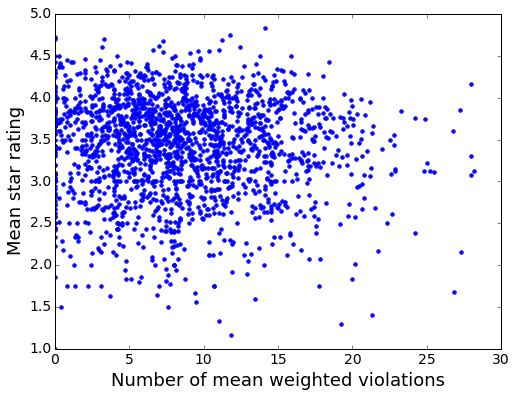

In [11]:
plt.plot(stars_violations[('weighted_violations', 'mean')], stars_violations[('stars', 'mean')], '.')
plt.xlabel('Number of mean weighted violations')
plt.ylabel('Mean star rating')
plt.xlim(0, 30)

In [12]:
from scipy.stats import pearsonr
pearsonr(stars_violations[('weighted_violations', 'mean')], stars_violations[('stars', 'mean')])

(-0.052577761968863386, 0.022087083413908221)

We have seen this plot before using the Yelp business data. Here the star values are not rounded to 1/2 so it is more continuous but there is no clear correlation despite one's intuition.

(0, 5000)

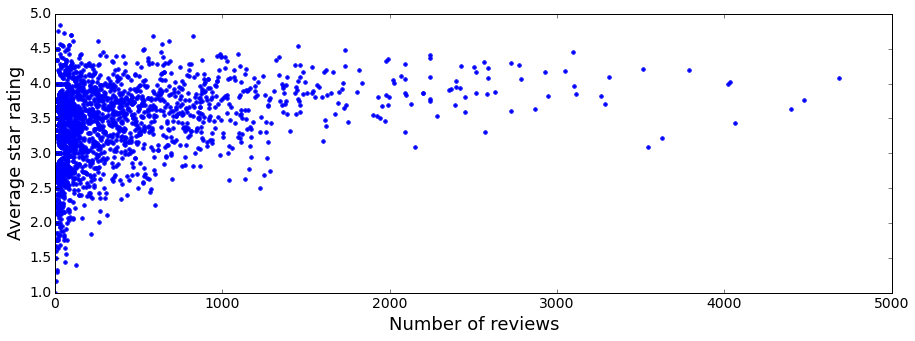

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(avg_stars[('stars', 'sum')], avg_stars[('stars', 'mean')], '.')
plt.xlabel('Number of reviews')
plt.ylabel('Average star rating')
plt.xlim(0, 5000)

In [14]:
pearsonr(avg_stars[('stars', 'sum')], avg_stars[('stars', 'mean')])

(0.28855600219118571, 2.5112521526774628e-38)

There is a positive correlation between star rating and number of reviews. Good restaurants tend to get more reviews.

### Let's examine the text of each review 

First, how many reviews does each restaurant have?

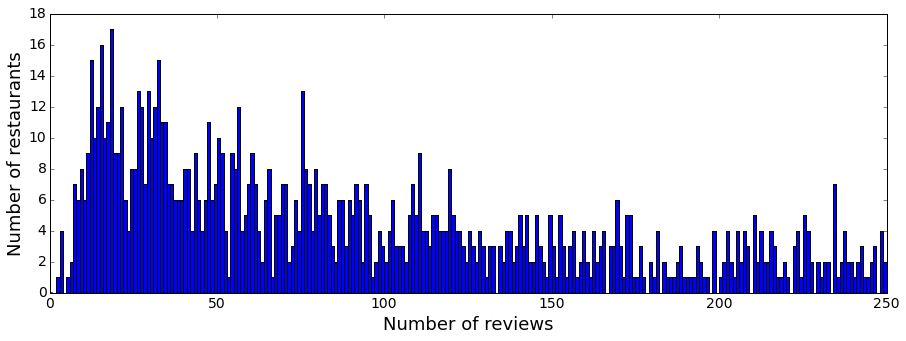

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.hist(avg_stars[('stars', 'sum')], bins=250, range=(0, 250))
plt.xlabel('Number of reviews')
plt.ylabel('Number of restaurants')

### Exploratory data analysis concludes here. Now we begin the model building:

Our strategy is to pair the inspection results with the reviews that were written in the t_days before the inspection. For instance, if the inspection was on March 1 then we would consider all reviews written between then and March 1 minus t_days. We do not consider reviews beyond the inspection date because the way the contest works we will be predicting violations using only past data.

In [16]:
# number of days in the review window 
t_days = 14

In [17]:
df_id = pd.merge(df, trans, on='restaurant_id', how='inner')
df_id.head()

,id,inspect_date,restaurant_id,*,**,***,weighted_violations,business_id
0,589,2010-02-02,KAoKWjog,3,0,1,8,DD_A7DaGDGEHJnw_KTMPKQ
1,4404,2010-09-20,KAoKWjog,3,0,0,3,DD_A7DaGDGEHJnw_KTMPKQ
2,7205,2012-02-13,KAoKWjog,4,1,1,12,DD_A7DaGDGEHJnw_KTMPKQ
3,3519,2009-08-04,KAoKWjog,0,0,0,0,DD_A7DaGDGEHJnw_KTMPKQ
4,2024,2012-01-31,KAoKWjog,4,1,1,12,DD_A7DaGDGEHJnw_KTMPKQ


In [18]:
df_rev[['business_id', 'text', 'review_date']].head()

,business_id,text,review_date
0,Jp9svt7sRT4zwdbzQ8KQmw,pretti typic cafe sandwich wrap good littl ove...,2005-08-26
1,Jp9svt7sRT4zwdbzQ8KQmw,agre review pretti typic financi district cafe...,2005-11-23
2,Jp9svt7sRT4zwdbzQ8KQmw,decent enough food overpr larg soup almost spe...,2005-11-23
3,Jp9svt7sRT4zwdbzQ8KQmw,muffin great esp blueberri never good blueberr...,2006-02-24
4,Jp9svt7sRT4zwdbzQ8KQmw,well well well look review restaur lobbi rebec...,2007-09-06


In [19]:
xl = pd.merge(df_id, df_rev, on='business_id', how='outer')
xl = xl[((xl['inspect_date'] - xl['review_date']) / np.timedelta64(1, 'D') > 0) & ((xl['inspect_date'] - xl['review_date']) / np.timedelta64(1, 'D') <= t_days)]
xl.drop(['id', 'weighted_violations', 'business_id', 'review_id', 'votes', 'type', 'user_id'], axis=1, inplace=True)
xl.head()

,inspect_date,restaurant_id,*,**,***,review_date,stars,text
349,2013-01-03,KAoKWjog,6.0,1.0,0.0,2012-12-26,4,ve go year especi breakfast get real good meal...
396,2014-11-13,KAoKWjog,8.0,1.0,3.0,2014-11-08,4,absolut banger drench drunk munch morn though ...
538,2012-12-30,KAoKWjog,0.0,0.0,0.0,2012-12-26,4,ve go year especi breakfast get real good meal...
583,2009-12-10,p038M4om,2.0,0.0,0.0,2009-12-03,3,food good yum canneloni place awkward alway em...
789,2014-04-28,p038M4om,0.0,0.0,0.0,2014-04-15,5,stay two night dorchest air trip lax logan sta...


In [20]:
xl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18188 entries, 349 to 3762876
Data columns (total 8 columns):
inspect_date     18188 non-null datetime64[ns]
restaurant_id    18188 non-null object
*                18188 non-null float64
**               18188 non-null float64
***              18188 non-null float64
review_date      18188 non-null datetime64[ns]
stars            18188 non-null int64
text             18188 non-null object
dtypes: datetime64[ns](2), float64(3), int64(1), object(2)
memory usage: 1.2+ MB


With t-days = 60, this leaves us with 78000 reviews that are within 60 days of the inspection. We can now associate the violations with the words in the reviews. This will be done using bag of words with TF-IDF and a regression model.

Prepare and store the features and response:

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 1), smooth_idf=True, norm='l2')
X_train = tfidf.fit_transform(xl['text'].values)
y_train = xl['*'].values

Because we work with a sparse matrix, we will not standardize each column since that would lead to a dense matrix and high memory demands.

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_train_pred = linreg.predict(X_train)
print 'Linear model: mse =', mse(y_train, y_train_pred)

#rf = RandomForestRegressor(n_estimators=10, criterion='mse')
#rf.fit(X_train, y_train)
#y_train_pred = rf.predict(X_train)
#print 'RF model: mse =', mse(y_train, y_train_pred)

Linear model: mse = 20.3366626412


In [23]:
#for x in sorted(zip(linreg.coef_, count.vocabulary_)):
#    print x

# Predictions for phase II

First note the last review was written on 2015-6-10. The first and last prediction dates are 2015-07-07 and 2015-08-18. This means there is nearly a month without Yelp reviews before the first prediction and then an additional six weeks before the last prediction date. Because of this we will formulate our model by including all reviews for a given restaurant written within 60 days of 2015-6-10.

In [24]:
t_days = 60

In [25]:
cutoff = df_rev['review_date'].sort_values(ascending=False)[:5]
cutoff[:5]

235068   2015-06-10
230693   2015-06-10
231960   2015-06-10
232761   2015-06-10
231895   2015-06-10
Name: review_date, dtype: datetime64[ns]

In [26]:
cutoff = cutoff.iloc[0]
cutoff

Timestamp('2015-06-10 00:00:00')

Load the submission data and make predictions:

In [78]:
df_sub = pd.read_csv('PhaseIISubmissionFormat.csv')
df_sub['date'] = pd.to_datetime(df_sub['date'])
df_sub.rename(columns={'date':'inspect_date'}, inplace=True)
df_sub.head()

,id,inspect_date,restaurant_id,*,**,***
0,42065,2015-07-07,6VOp6a3L,0.0,0.0,0.0
1,73703,2015-07-07,1JEbP4oR,0.0,0.0,0.0
2,19212,2015-07-07,Pk3w02od,0.0,0.0,0.0
3,15332,2015-07-07,N6OkmQ3x,0.0,0.0,0.0
4,59579,2015-07-07,v5oJKbOB,0.0,0.0,0.0


In [79]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80281 entries, 0 to 80280
Data columns (total 6 columns):
id               80281 non-null int64
inspect_date     80281 non-null datetime64[ns]
restaurant_id    80281 non-null object
*                80281 non-null float64
**               80281 non-null float64
***              80281 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 3.7+ MB


In [80]:
for column in df_sub.columns:
    print df_sub.shape[0], df_sub[column].unique().size, column

80281 80281 id
80281 43 inspect_date
80281 1867 restaurant_id
80281 1 *
80281 1 **
80281 1 ***


In [81]:
df_sub = pd.merge(df_sub, trans, on='restaurant_id', how='left')
df_sub.head()

,id,inspect_date,restaurant_id,*,**,***,business_id
0,42065,2015-07-07,6VOp6a3L,0.0,0.0,0.0,atafOjxJyt4ohXWJLt6UaQ
1,73703,2015-07-07,1JEbP4oR,0.0,0.0,0.0,1EjS_EEJ1iFMMZrt6FVXQQ
2,19212,2015-07-07,Pk3w02od,0.0,0.0,0.0,GAdqjmUmn_ibbfvo0wArIQ
3,15332,2015-07-07,N6OkmQ3x,0.0,0.0,0.0,erebWqQMcrr1FCzmyhZkMg
4,59579,2015-07-07,v5oJKbOB,0.0,0.0,0.0,MOcHiAoNyDZIEs43b_hkKg


In [82]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82173 entries, 0 to 82172
Data columns (total 7 columns):
id               82173 non-null int64
inspect_date     82173 non-null datetime64[ns]
restaurant_id    82173 non-null object
*                82173 non-null float64
**               82173 non-null float64
***              82173 non-null float64
business_id      82173 non-null object
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 5.0+ MB


In [83]:
for column in df_sub.columns:
    print df_sub.shape[0], df_sub[column].unique().size, column

82173 80281 id
82173 43 inspect_date
82173 1867 restaurant_id
82173 1 *
82173 1 **
82173 1 ***
82173 1911 business_id


Because restaurant id's may have multiple (up to 4) business id's associated with them, the length of the data frame has increased.

In [31]:
bg = pd.merge(df_sub, df_rev, on='business_id', how='left')
bg = bg[((cutoff - bg['review_date']) / np.timedelta64(1, 'D') < t_days)]
bg.drop(['id', 'business_id', 'review_id', 'stars', 'votes', 'type', 'user_id'], axis=1, inplace=True)
bg.head(3)

,inspect_date,restaurant_id,*,**,***,review_date,text
161,2015-07-07,6VOp6a3L,0.0,0.0,0.0,2015-05-02,solid craft beer select nice ambienc good food...
165,2015-07-07,6VOp6a3L,0.0,0.0,0.0,2015-05-09,usual leav review disappoint enough first last...
166,2015-07-07,6VOp6a3L,0.0,0.0,0.0,2015-05-12,poor servic expens


In [33]:
bg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246261 entries, 161 to 10046820
Data columns (total 7 columns):
inspect_date     246261 non-null datetime64[ns]
restaurant_id    246261 non-null object
*                246261 non-null float64
**               246261 non-null float64
***              246261 non-null float64
review_date      246261 non-null datetime64[ns]
text             246261 non-null object
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 15.0+ MB


In [84]:
for column in bg.columns:
    print bg.shape[0], bg[column].unique().size, column

246261 43 inspect_date
246261 981 restaurant_id
246261 1 *
246261 1 **
246261 1 ***
246261 60 review_date
246261 5621 text
246261 5 *-predict


What are the fewest and most number of reviews per restaurant?

In [85]:
bg_by_restaurant = bg.groupby('restaurant_id').size()
print 'min:', bg_by_restaurant.min(), '  max:', bg_by_restaurant.max()

min: 43   max: 4214


We see there are 43 reviews at a minimum.

In [34]:
bg['*-predict'] = linreg.predict(tfidf.transform(bg['text'].values))
bg.head()

,inspect_date,restaurant_id,*,**,***,review_date,text,*-predict
161,2015-07-07,6VOp6a3L,0.0,0.0,0.0,2015-05-02,solid craft beer select nice ambienc good food...,4.0
165,2015-07-07,6VOp6a3L,0.0,0.0,0.0,2015-05-09,usual leav review disappoint enough first last...,5.0
166,2015-07-07,6VOp6a3L,0.0,0.0,0.0,2015-05-12,poor servic expens,5.0
295,2015-07-07,v5oJKbOB,0.0,0.0,0.0,2015-06-06,given happi garden anoth tri food significantl...,5.0
592,2015-07-07,0ZEDMl3D,0.0,0.0,0.0,2015-04-27,thai place best thai food boston tri black egg...,4.0


In [48]:
mean_violations = bg.groupby('restaurant_id').agg({'*-predict':[np.mean]})
pred = pd.merge(df_sub, mean_violations, left_on='restaurant_id', right_index=True, how='left')
pred.head()

,id,inspect_date,restaurant_id,*,**,***,business_id,"(*-predict, mean)"
0,42065,2015-07-07,6VOp6a3L,0.0,0.0,0.0,atafOjxJyt4ohXWJLt6UaQ,4.666667
1,73703,2015-07-07,1JEbP4oR,0.0,0.0,0.0,1EjS_EEJ1iFMMZrt6FVXQQ,NaN
2,19212,2015-07-07,Pk3w02od,0.0,0.0,0.0,GAdqjmUmn_ibbfvo0wArIQ,NaN
3,15332,2015-07-07,N6OkmQ3x,0.0,0.0,0.0,erebWqQMcrr1FCzmyhZkMg,NaN
4,59579,2015-07-07,v5oJKbOB,0.0,0.0,0.0,MOcHiAoNyDZIEs43b_hkKg,5.000000


In [49]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82173 entries, 0 to 82172
Data columns (total 8 columns):
id                   82173 non-null int64
inspect_date         82173 non-null datetime64[ns]
restaurant_id        82173 non-null object
*                    82173 non-null float64
**                   82173 non-null float64
***                  82173 non-null float64
business_id          82173 non-null object
(*-predict, mean)    43430 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 5.6+ MB


In [46]:
pred[('*-predict', 'mean')].fillna(3, inplace=True)
pred[('*-predict', 'mean')] = pred[('*-predict', 'mean')].apply(lambda x: int(round(x)))
pred.head()

,id,inspect_date,restaurant_id,*,**,***,business_id,"(*-predict, mean)"
0,42065,2015-07-07,6VOp6a3L,0.0,0.0,0.0,atafOjxJyt4ohXWJLt6UaQ,5
1,73703,2015-07-07,1JEbP4oR,0.0,0.0,0.0,1EjS_EEJ1iFMMZrt6FVXQQ,3
2,19212,2015-07-07,Pk3w02od,0.0,0.0,0.0,GAdqjmUmn_ibbfvo0wArIQ,3
3,15332,2015-07-07,N6OkmQ3x,0.0,0.0,0.0,erebWqQMcrr1FCzmyhZkMg,3
4,59579,2015-07-07,v5oJKbOB,0.0,0.0,0.0,MOcHiAoNyDZIEs43b_hkKg,5
